<a href="https://colab.research.google.com/github/Userfound404/GANs/blob/main/QGANs_swapTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,AdamOptimizer,MomentumOptimizer,QNGOptimizer
from sklearn.preprocessing import scale, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
# %matplotlib qt
from skimage.transform import resize

In [3]:
batch_size = 64
imsize = 16
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)
train_images_resize = tf.image.resize(train_images, [imsize,imsize]).numpy()
train_images_resize= train_images_resize.reshape(60000, imsize**2)
train_images_resize = train_images_resize/255
mnist_dataset = normalize(train_images_resize[:20000])
train_labels = train_labels[:20000]

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
mnist_dataset.shape

(20000, 256)

In [7]:
k = 4
pca = PCA(n_components = k)
pca.fit(mnist_dataset)
print("variance Ratio", pca.explained_variance_ratio_)
print("variance Cummalative Ratio", sum(pca.explained_variance_ratio_))

X = pca.transform(mnist_dataset)

number1 = 1
valid_labels = train_labels == number1 

number_ind = [i for i, e in enumerate(train_labels) if e == number1]


variance Ratio [0.10873813 0.07881602 0.06815814 0.05558349]
variance Cummalative Ratio 0.311295785009861


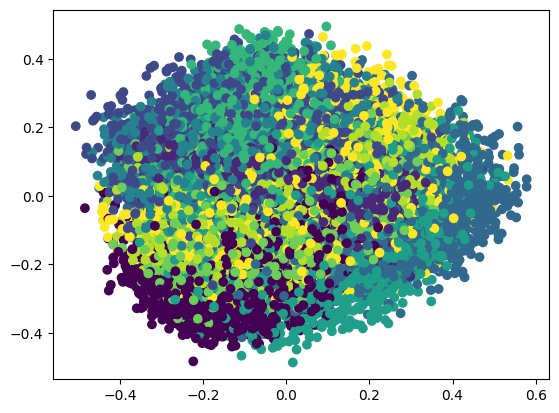

In [8]:
plt.scatter(X[:,2], X[:,3],c=train_labels)
plt.show()

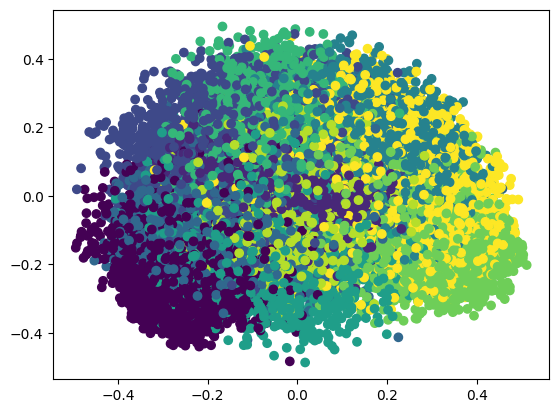

In [9]:
plt.scatter(X[:,1], X[:,3],c=train_labels)
plt.show()

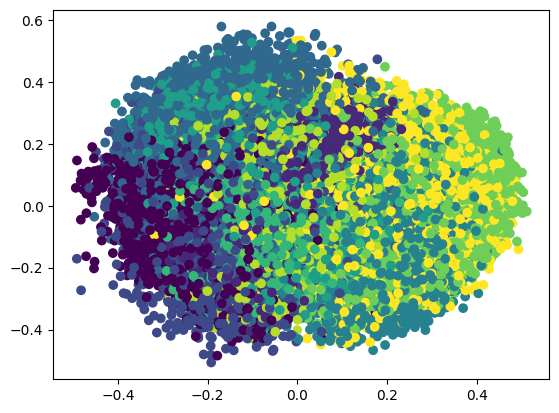

In [10]:
plt.scatter(X[:,1], X[:,2],c=train_labels)
plt.show()

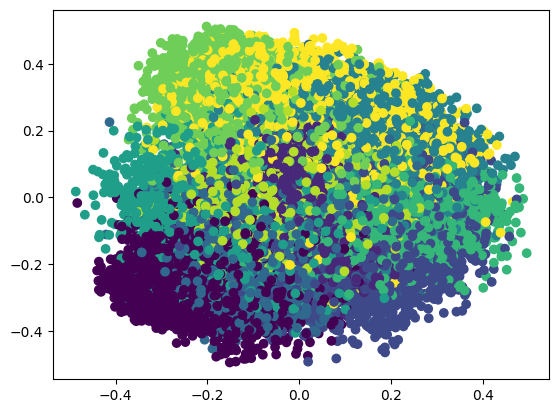

In [12]:
plt.scatter(X[:,3], X[:,1],c=train_labels)
plt.show()

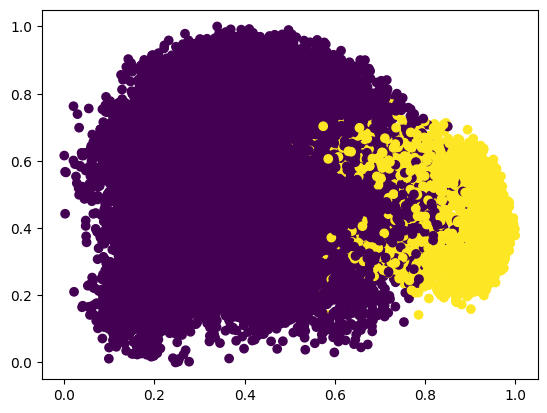

In [15]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1],c=valid_labels)
plt.show()

In [16]:
x_in = []
for i in range(len(number_ind)):
    x_in.append(X[number_ind[i]])
    
print("Number of Real Data = ", len(x_in))

Number of Real Data =  2281


In [17]:
pca_data = 2*np.arcsin(np.sqrt(x_in)) 
print(x_in)

[array([0.8535098 , 0.31613353, 0.27037412, 0.5766089 ], dtype=float32), array([0.69106174, 0.62152547, 0.7315676 , 0.5558047 ], dtype=float32), array([0.775316 , 0.6249366, 0.6792646, 0.4422672], dtype=float32), array([0.81816137, 0.5654217 , 0.6287439 , 0.455321  ], dtype=float32), array([0.839026  , 0.34915608, 0.26568425, 0.6057985 ], dtype=float32), array([0.5873053 , 0.41808382, 0.44273642, 0.4610094 ], dtype=float32), array([0.93722206, 0.5624602 , 0.625254  , 0.43801147], dtype=float32), array([0.8724666 , 0.25021935, 0.32558578, 0.55710703], dtype=float32), array([0.96590376, 0.41332   , 0.42849588, 0.5651635 ], dtype=float32), array([0.5989468 , 0.35358194, 0.67131203, 0.543493  ], dtype=float32), array([0.87521917, 0.525366  , 0.5664464 , 0.49813372], dtype=float32), array([0.9346133 , 0.30535233, 0.39406204, 0.53367704], dtype=float32), array([0.8964355 , 0.4799588 , 0.3238271 , 0.60402846], dtype=float32), array([0.9071678 , 0.45283875, 0.37478176, 0.5415633 ], dtype=float

In [18]:

dev = qml.device("default.qubit", wires= 2 * k + 1)
gen_dev = qml.device("default.qubit", wires=k)

In [19]:
def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires= k + i)

In [20]:
def generator_sample(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires=h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[l-1, l])
            
def generator(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires= k + h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires= k + j)
        if i % 2 == 0:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[k+(l-1), k + l])

In [21]:
def discriminator(w):
    W = np.reshape(w, (layers, k))
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
#         if i % 2 == 0:
        for l in range(1, len(W[i])):
            qml.CNOT(wires=[l-1, l])

In [22]:
# For real data set
@qml.qnode(dev)
def real_disc_circuit(x_in_l, disc_weights):
    qml.Hadamard(wires= 2 * k)
    discriminator(disc_weights)
    real(x_in_l)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# For Generated data set
@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    qml.Hadamard(wires= 2 * k)
    generator(gen_weights)
    discriminator(disc_weights)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# Exract Synthetic data from Generator:
gen_dev.shots = 20
@qml.qnode(gen_dev)
def gen_data(gen_weights):
    generator_sample(gen_weights)
    exp = [qml.sample(qml.PauliZ(i)) for i in range(k)]
    return exp

In [23]:
def prob_real_true(x_in_l, disc_weights):
    true_disc_output = real_disc_circuit(x_in_l, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

# def prob_fakeReal_true(x_in_f, disc_weights):
#     fake_disc_output = real_disc_circuit(x_in_f, disc_weights)
#     # convert to probability
#     prob_fake_true = (fake_disc_output + 1) / 2
#     return prob_fake_true

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true  # generator wants to minimize this prob


def disc_cost(x_in_l, gen_weights, disc_weights):
    cost = 0
    for i in range(len(x_in_l)):
        cost += prob_fake_true(gen_weights, disc_weights) - prob_real_true(x_in_l[i], disc_weights)
#         cost += -1 * (np.log(1 - prob_fake_true(gen_weights, disc_weights)) + np.log(prob_real_true(x_in_l[i], disc_weights)))
    return cost / len(x_in_l)


def gen_cost(gen_weights, disc_weights):
    cost = 0
    for i in range(batch_size):
        cost += prob_fake_true(gen_weights, disc_weights)
#         cost += np.log(1 - prob_fake_true(gen_weights, disc_weights))
    return -(cost / batch_size)

In [24]:
layers = 4
eps = 1e-2
mulpt = 2
gen_weights = np.array([np.pi] + [0] * (layers * k - 1)) + np.random.normal(scale=eps, size=[layers * k])
disc_weights = np.random.normal(size=[k * layers])
drawer = qml.draw(real_disc_circuit, max_length=100)
print(drawer(x_in[0], disc_weights))

0: ──RY(-0.37)─╭●──RY(0.77)───────────╭●─────────RY(-2.33)────────────╭●─────────RY(0.14)──────────
1: ──RY(-0.30)─╰X─╭●─────────RY(3.09)─╰X────────╭●──────────RY(-0.34)─╰X────────╭●─────────RY(1.38)
2: ──RY(-0.77)────╰X────────╭●─────────RY(0.52)─╰X─────────╭●──────────RY(2.29)─╰X────────╭●───────
3: ──RY(-0.62)──────────────╰X─────────RY(0.22)────────────╰X──────────RY(0.85)───────────╰X───────
4: ──RY(0.85)──────────────────────────────────────────────────────────────────────────────────────
5: ──RY(0.32)──────────────────────────────────────────────────────────────────────────────────────
6: ──RY(0.27)──────────────────────────────────────────────────────────────────────────────────────
7: ──RY(0.58)──────────────────────────────────────────────────────────────────────────────────────
8: ──H─────────────────────────────────────────────────────────────────────────────────────────────

──╭●──────────────╭SWAP──────────────────────┤     
──╰X────────╭●────│─────╭SWAP────────────────┤ 

In [25]:
drawer = qml.draw(gen_disc_circuit, max_length=100)
print(drawer(gen_weights, disc_weights))

0: ──RY(-0.37)─╭●──────────RY(0.77)───────────╭●──────────RY(-2.33)────────────╭●──────────RY(0.14)─
1: ──RY(-0.30)─╰X─────────╭●─────────RY(3.09)─╰X─────────╭●──────────RY(-0.34)─╰X─────────╭●────────
2: ──RY(-0.77)────────────╰X────────╭●─────────RY(0.52)──╰X─────────╭●──────────RY(2.29)──╰X────────
3: ──RY(-0.62)──────────────────────╰X─────────RY(0.22)─────────────╰X──────────RY(0.85)────────────
4: ──H──────────RY(3.12)──╭●─────────RY(0.01)──RY(0.03)─────────────╭●──────────RY(-0.01)───────────
5: ──H──────────RY(0.01)──╰X────────╭●─────────RY(-0.01)──RY(-0.00)─╰X─────────╭●──────────RY(-0.01)
6: ──H──────────RY(-0.01)───────────╰X────────╭●──────────RY(-0.01)──RY(-0.01)─╰X─────────╭●────────
7: ──H──────────RY(-0.00)─────────────────────╰X──────────RY(0.01)───RY(-0.01)────────────╰X────────
8: ──H──────────────────────────────────────────────────────────────────────────────────────────────

─────────────╭●──────────────╭SWAP──────────────────────┤     
───RY(1.38)──╰X────────╭●──

In [26]:
opt = GradientDescentOptimizer(0.05)

Starting Epoch :  0
Step 1: cost = 0.04174486430749023
Step 65: cost = 0.04008208989353435
Step 129: cost = 0.03851108429123912
Step 193: cost = 0.036921159184222355
Step 257: cost = 0.03546085102179616
Step 321: cost = 0.03400259667171561
Step 385: cost = 0.03223512634648256
Step 449: cost = 0.031107750431391357
Step 513: cost = 0.02964045465362836
Step 577: cost = 0.028261716849813094
Step 641: cost = 0.026758020532291257
Step 705: cost = 0.02538570520956324
Step 769: cost = 0.02422894195484388
Step 833: cost = 0.022630209572680346
Step 897: cost = 0.021616333970860407
Step 961: cost = 0.020131243649076522
Step 1025: cost = 0.018846507269162236
Step 1089: cost = 0.01770537302732536
Step 1153: cost = 0.016507870060997368
Step 1217: cost = 0.015319025934303157
Step 1281: cost = 0.013980959863936404
Step 1345: cost = 0.012953053196462023
Step 1409: cost = 0.011465616273984994
Step 1473: cost = 0.010709481307339177
Step 1537: cost = 0.009350274008199964
Step 1601: cost = 0.00766412284632

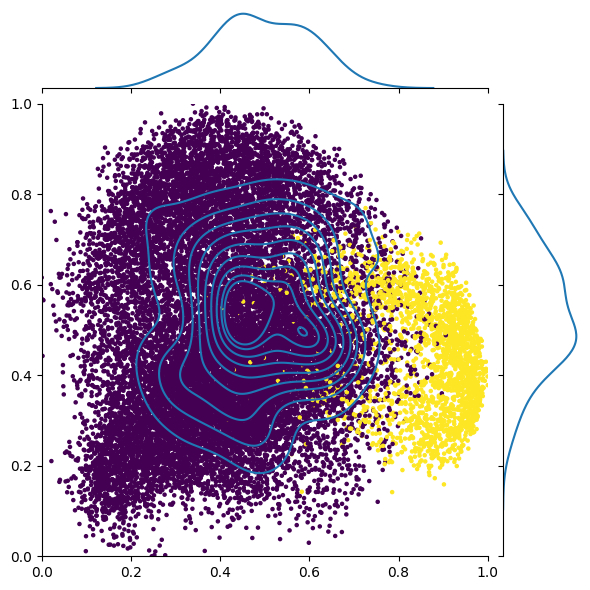

Starting Epoch :  1
Step 1: cost = 0.0016474050760753693
Step 65: cost = 0.0002543632341872083
Step 129: cost = -0.0011375200793862505
Step 193: cost = -0.002614596686369885
Step 257: cost = -0.004533812562705996
Step 321: cost = -0.00717801737649003
Step 385: cost = -0.007634979229969691
Step 449: cost = -0.009821476352075453
Step 513: cost = -0.011792467310634802
Step 577: cost = -0.013889493609567075
Step 641: cost = -0.015533034154301526
Step 705: cost = -0.016815367508306145
Step 769: cost = -0.018718278901604248
Step 833: cost = -0.02083119883648811
Step 897: cost = -0.02181147788315766
Step 961: cost = -0.024252528115743518
Step 1025: cost = -0.025783626539404123
Step 1089: cost = -0.02715796689812691
Step 1153: cost = -0.028297179356974886
Step 1217: cost = -0.030145471967653027
Step 1281: cost = -0.033272610711038896
Step 1345: cost = -0.034000410385394
Step 1409: cost = -0.03698726313719795
Step 1473: cost = -0.03866979498772361
Step 1537: cost = -0.04051462466336617
Step 160

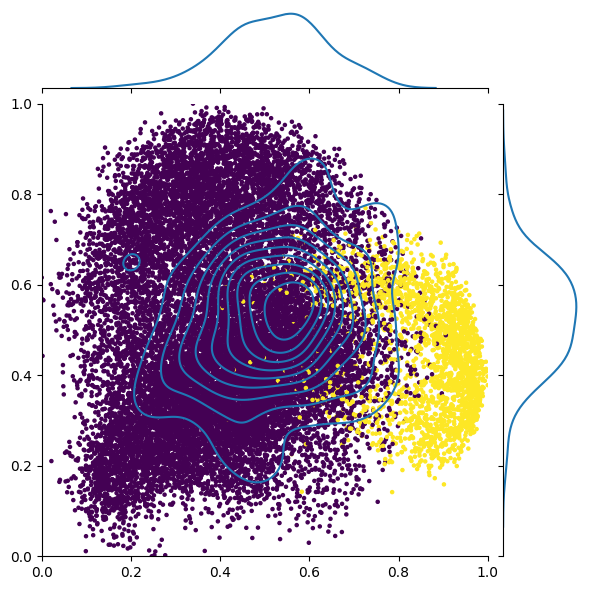

Starting Epoch :  2
Step 1: cost = -0.06193746581087035
Step 65: cost = -0.06547002354681512
Step 129: cost = -0.06544639991542836
Step 193: cost = -0.06935137839890808
Step 257: cost = -0.06961596741686127
Step 321: cost = -0.07206369704570938
Step 385: cost = -0.07509944497259136
Step 449: cost = -0.08008633661862773
Step 513: cost = -0.08069082262611059
Step 577: cost = -0.08517974736714042
Step 641: cost = -0.08643512354416065
Step 705: cost = -0.08893154621922822
Step 769: cost = -0.09049869560299265
Step 833: cost = -0.09302010673734057
Step 897: cost = -0.09756043317445547
Step 961: cost = -0.09554073710763203
Step 1025: cost = -0.10037424388070659
Step 1089: cost = -0.1007812728326817
Step 1153: cost = -0.10549829650564038
Step 1217: cost = -0.1067717796146108
Step 1281: cost = -0.11213253783523205
Step 1345: cost = -0.11312206660880048
Step 1409: cost = -0.11853205646941233
Step 1473: cost = -0.11636020001654929
Step 1537: cost = -0.12158823007462277
Step 1601: cost = -0.12624

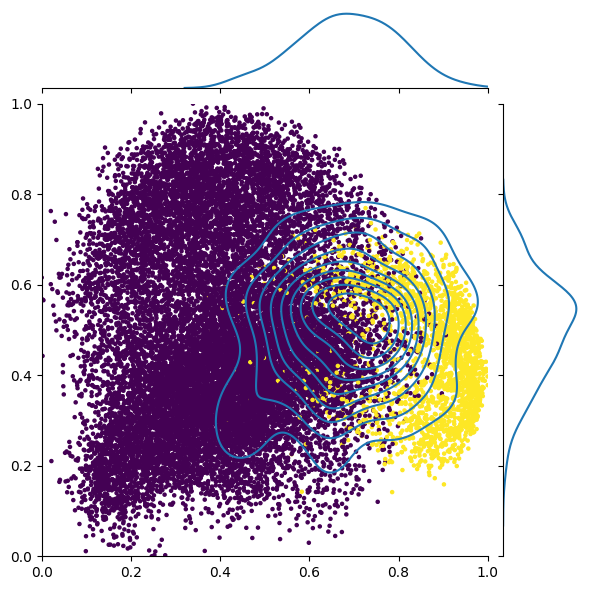

Starting Epoch :  3
Step 1: cost = -0.11062275877392001
Step 65: cost = -0.11178360835397681
Step 129: cost = -0.11694197129060199
Step 193: cost = -0.11849933040243622
Step 257: cost = -0.120183967958708
Step 321: cost = -0.128568108413229
Step 385: cost = -0.1263449526835018
Step 449: cost = -0.12939247090184713
Step 513: cost = -0.12911293003466032
Step 577: cost = -0.13422637645763227
Step 641: cost = -0.1389839907337711
Step 705: cost = -0.14231626724235286
Step 769: cost = -0.14288271354623416
Step 833: cost = -0.14638649679867274
Step 897: cost = -0.14744968520043406
Step 961: cost = -0.14752123823980295
Step 1025: cost = -0.15403406943618486
Step 1089: cost = -0.15927375204201902
Step 1153: cost = -0.15935138291774806
Step 1217: cost = -0.16301095165028776
Step 1281: cost = -0.16613862701610196
Step 1345: cost = -0.1668492727040276
Step 1409: cost = -0.17066442390995834
Step 1473: cost = -0.16818769785104942
Step 1537: cost = -0.1749140931452685
Step 1601: cost = -0.17695154831

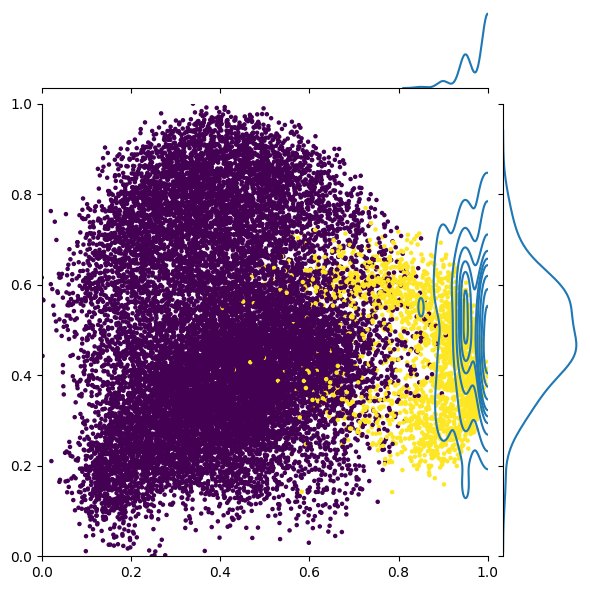

Starting Epoch :  4
Step 1: cost = -0.023487452771012413
Step 65: cost = -0.03387623741568922
Step 129: cost = -0.03840512117614433
Step 193: cost = -0.037597131446563015
Step 257: cost = -0.03996233210650402
Step 321: cost = -0.0452438044686935
Step 385: cost = -0.04532026365104916
Step 449: cost = -0.045010008626915135
Step 513: cost = -0.050908049946015166
Step 577: cost = -0.05549710662997382
Step 641: cost = -0.058203907390517506
Step 705: cost = -0.053012230762280795
Step 769: cost = -0.06195424022346774
Step 833: cost = -0.06260445871486148
Step 897: cost = -0.06484441181985767
Step 961: cost = -0.06427101408836573
Step 1025: cost = -0.06378976442267001
Step 1089: cost = -0.0727019304350114
Step 1153: cost = -0.06974064320149262
Step 1217: cost = -0.07061904555608067
Step 1281: cost = -0.07444573595381915
Step 1345: cost = -0.07780079779211872
Step 1409: cost = -0.0783521490889593
Step 1473: cost = -0.07725897278550276
Step 1537: cost = -0.08002082468029084
Step 1601: cost = -0.

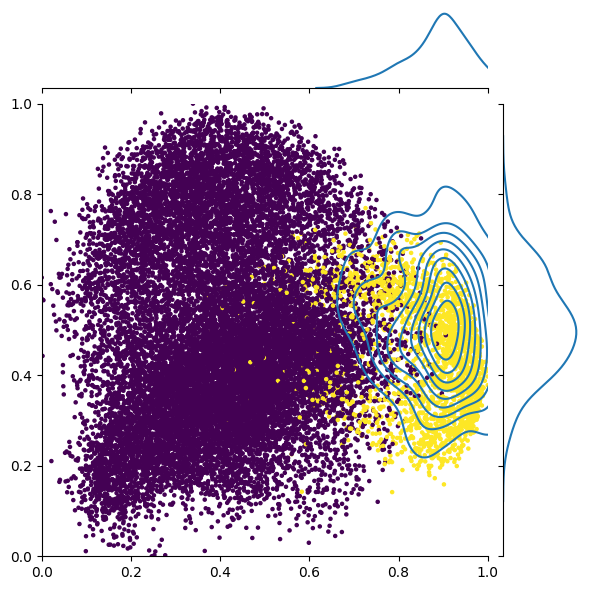

Starting Epoch :  5
Step 1: cost = 0.08976098981898438
Step 65: cost = 0.07318892847696008
Step 129: cost = 0.0712759562631541
Step 193: cost = 0.07509414036023018
Step 257: cost = 0.0680467191020797
Step 321: cost = 0.07373756430834616
Step 385: cost = 0.07128711643961987
Step 449: cost = 0.06721906655711951
Step 513: cost = 0.06694633618325174
Step 577: cost = 0.06425950364203578
Step 641: cost = 0.06328638094554138
Step 705: cost = 0.05995422722205822
Step 769: cost = 0.06778412702449639
Step 833: cost = 0.05965975588678947
Step 897: cost = 0.06499007179898866
Step 961: cost = 0.06320163537470892
Step 1025: cost = 0.06439140139885043
Step 1089: cost = 0.06030042710870449
Step 1153: cost = 0.06367138980632664
Step 1217: cost = 0.05692053746804488
Step 1281: cost = 0.06387675240510016
Step 1345: cost = 0.05525228351982416
Step 1409: cost = 0.06376794473743794
Step 1473: cost = 0.061877068106811366
Step 1537: cost = 0.05831832991999885
Step 1601: cost = 0.05663482186292129
Step 1665: c

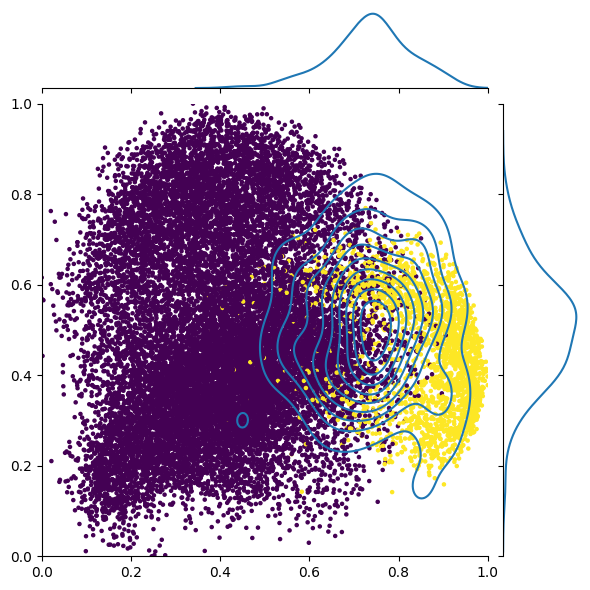

Starting Epoch :  6
Step 1: cost = 0.09748749980549223
Step 65: cost = 0.09151059373436506
Step 129: cost = 0.08021563784608098
Step 193: cost = 0.07825292646197052
Step 257: cost = 0.07550360420997394
Step 321: cost = 0.06952315996644412
Step 385: cost = 0.0737609027646431
Step 449: cost = 0.07317821440196004
Step 513: cost = 0.06371370442868232
Step 577: cost = 0.06585186567034254
Step 641: cost = 0.06343631426686115
Step 705: cost = 0.0668378685361289
Step 769: cost = 0.06550090170497004
Step 833: cost = 0.0595022376999248
Step 897: cost = 0.0685074819187193
Step 961: cost = 0.06282768549268496
Step 1025: cost = 0.05862754043401057
Step 1089: cost = 0.05913293350811057
Step 1153: cost = 0.051539572824875424
Step 1217: cost = 0.0542102547378658
Step 1281: cost = 0.05214866169517282
Step 1345: cost = 0.050637213763859185
Step 1409: cost = 0.05081690777185532
Step 1473: cost = 0.05494828560409304
Step 1537: cost = 0.049790781173643536
Step 1601: cost = 0.04306076162238123
Step 1665: co

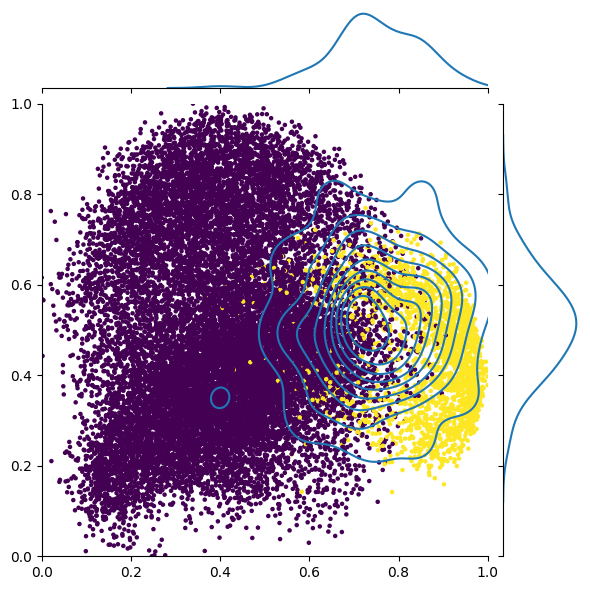

Starting Epoch :  7
Step 1: cost = 0.05795291746369721
Step 65: cost = 0.05611267738909431
Step 129: cost = 0.054049832727316324
Step 193: cost = 0.05195308991281844
Step 257: cost = 0.049712905809789806
Step 321: cost = 0.03818077023022206
Step 385: cost = 0.03964565968950484
Step 449: cost = 0.040164018757147965
Step 513: cost = 0.03882344539153938
Step 577: cost = 0.03912723039641438
Step 641: cost = 0.032643495037033
Step 705: cost = 0.032990444870877496
Step 769: cost = 0.03130231809414227
Step 833: cost = 0.032896993768614505
Step 897: cost = 0.0247725344273877
Step 961: cost = 0.027387429249242798
Step 1025: cost = 0.03134542282693932
Step 1089: cost = 0.029602794466817378
Step 1153: cost = 0.02589370327558751
Step 1217: cost = 0.026037683872520354
Step 1281: cost = 0.023029877493299156
Step 1345: cost = 0.025276956209356223
Step 1409: cost = 0.023032276339437625
Step 1473: cost = 0.021815080850424884
Step 1537: cost = 0.018940560932493716
Step 1601: cost = 0.01837513652956488
S

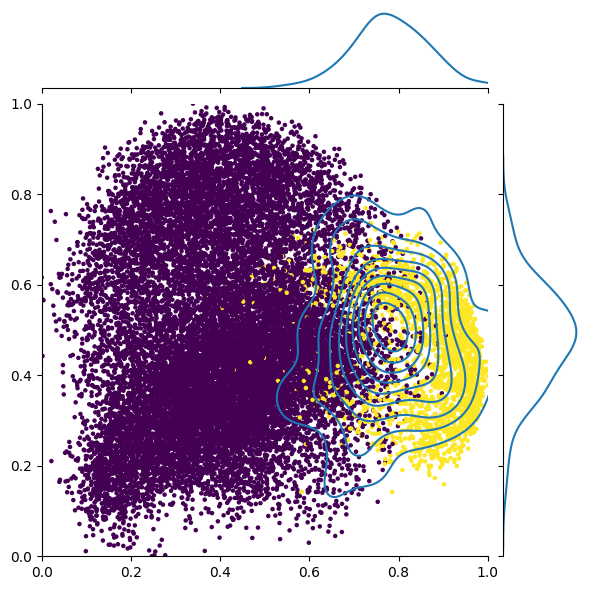

Starting Epoch :  8
Step 1: cost = 0.04057232088394821
Step 65: cost = 0.039965950498800466
Step 129: cost = 0.03737496497180711
Step 193: cost = 0.036692457710136295
Step 257: cost = 0.03746612093381005
Step 321: cost = 0.0359625161430295
Step 385: cost = 0.03228867503956041
Step 449: cost = 0.03230858968241791
Step 513: cost = 0.03190383536830074
Step 577: cost = 0.030007233674225343
Step 641: cost = 0.030318877623613377
Step 705: cost = 0.0294650252057687
Step 769: cost = 0.026971907583673217
Step 833: cost = 0.027565149044909653
Step 897: cost = 0.02726193860018488
Step 961: cost = 0.025759477727176634
Step 1025: cost = 0.026363561181845734
Step 1089: cost = 0.02713901987466166
Step 1153: cost = 0.024632755838392473
Step 1217: cost = 0.023198177323707315
Step 1281: cost = 0.025081060178797337
Step 1345: cost = 0.02277961416324952
Step 1409: cost = 0.021853336255442554
Step 1473: cost = 0.024311067588513702
Step 1537: cost = 0.020760897056590656
Step 1601: cost = 0.01838426855146868

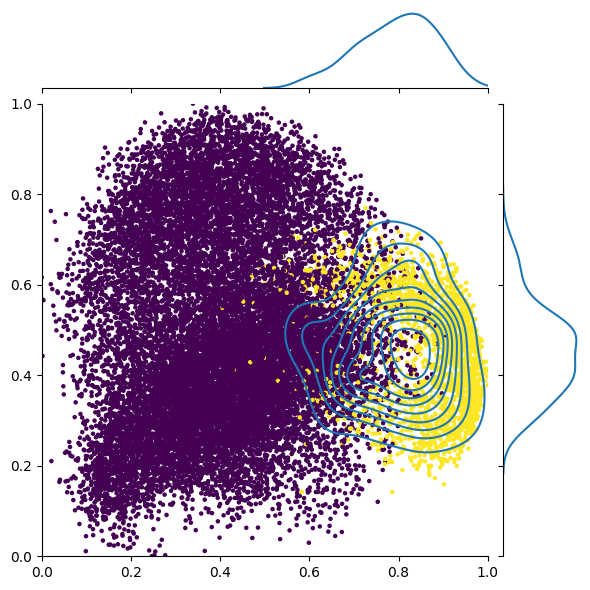

Starting Epoch :  9
Step 1: cost = 0.036807101529957253
Step 65: cost = 0.03675882307654324
Step 129: cost = 0.036123003031689915
Step 193: cost = 0.03545876025716066
Step 257: cost = 0.03383970272397298
Step 321: cost = 0.0349994944972165
Step 385: cost = 0.03377262924887713
Step 449: cost = 0.03267903997686144
Step 513: cost = 0.032400740575819
Step 577: cost = 0.03114063903484408
Step 641: cost = 0.03109145923108371
Step 705: cost = 0.030383170476040496
Step 769: cost = 0.03178446029185001
Step 833: cost = 0.028397793126355753
Step 897: cost = 0.029877541470085096
Step 961: cost = 0.0288654414531731
Step 1025: cost = 0.027179347758152145
Step 1089: cost = 0.029526683509823858
Step 1153: cost = 0.02804681331205527
Step 1217: cost = 0.027624471125986722
Step 1281: cost = 0.02662982809922626
Step 1345: cost = 0.02652689999330333
Step 1409: cost = 0.026660186565142255
Step 1473: cost = 0.025602797948495085
Step 1537: cost = 0.025859796271203273
Step 1601: cost = 0.02537975971716648
Step

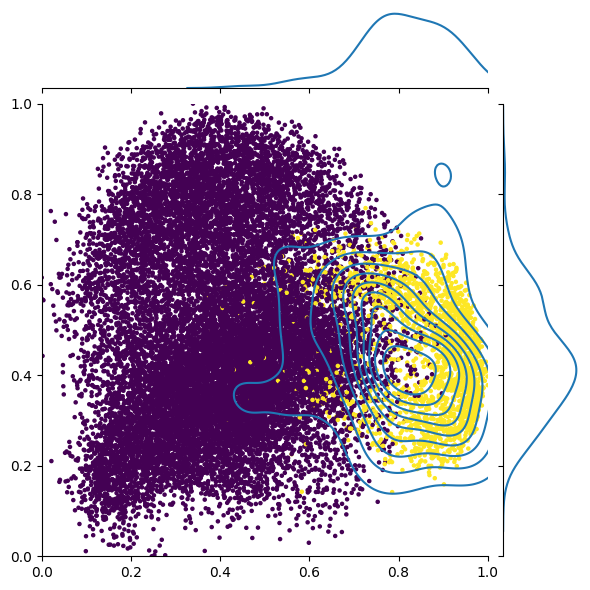

Starting Epoch :  10
Step 1: cost = 0.030842392329174684
Step 65: cost = 0.030414325828734275
Step 129: cost = 0.029947447443077396
Step 193: cost = 0.029516980788683332
Step 257: cost = 0.02838946208726811
Step 321: cost = 0.028647397904126518
Step 385: cost = 0.0281033717358899
Step 449: cost = 0.02778851062277111
Step 513: cost = 0.026792995788941384
Step 577: cost = 0.027040921826286434
Step 641: cost = 0.026188664977611804
Step 705: cost = 0.02538844513157333
Step 769: cost = 0.02545926415337195
Step 833: cost = 0.025061570431073772
Step 897: cost = 0.024752817045987884
Step 961: cost = 0.024004114105504938
Step 1025: cost = 0.023906059394706473
Step 1089: cost = 0.02345494962505528
Step 1153: cost = 0.022733190407261926
Step 1217: cost = 0.022077440199242834
Step 1281: cost = 0.02182175527081778
Step 1345: cost = 0.02161542319784311
Step 1409: cost = 0.02200940694977644
Step 1473: cost = 0.021578124827790795
Step 1537: cost = 0.02016187822859418
Step 1601: cost = 0.01982802717993

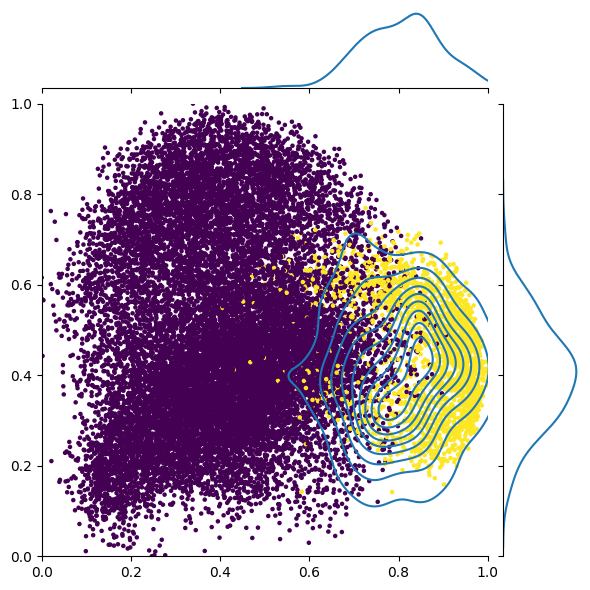

Starting Epoch :  11
Step 1: cost = 0.02064737857148033
Step 65: cost = 0.020221761838200257
Step 129: cost = 0.020282974291043455
Step 193: cost = 0.01988365313996463
Step 257: cost = 0.018905631831574517
Step 321: cost = 0.01933679544848299
Step 385: cost = 0.018895177828905776
Step 449: cost = 0.01883771657086032
Step 513: cost = 0.017892542668010276
Step 577: cost = 0.016866321776247896
Step 641: cost = 0.016468920424456905
Step 705: cost = 0.016337413713876234
Step 769: cost = 0.01714714270480689
Step 833: cost = 0.01550766950076471
Step 897: cost = 0.016082171527304782
Step 961: cost = 0.014556042375513233
Step 1025: cost = 0.015305250030748244
Step 1089: cost = 0.014096429057931225
Step 1153: cost = 0.015531825829053582
Step 1217: cost = 0.013328455247478162
Step 1281: cost = 0.012861100009152374
Step 1345: cost = 0.012143677800650303
Step 1409: cost = 0.013669215919678939
Step 1473: cost = 0.012566188675015195
Step 1537: cost = 0.01330767153199753
Step 1601: cost = 0.0117087450

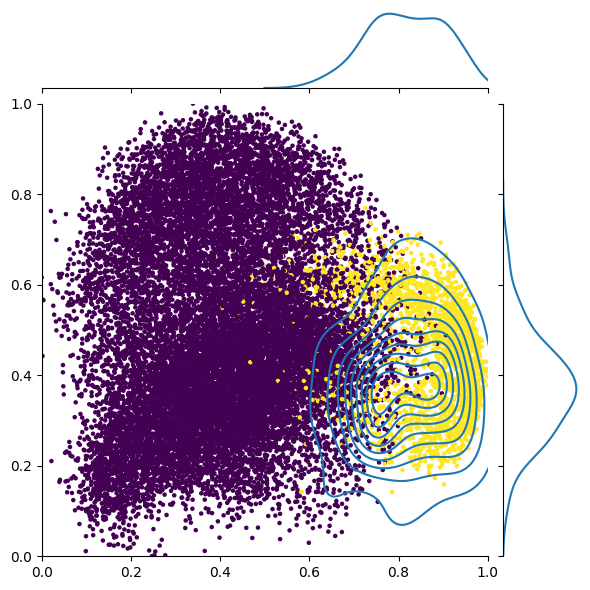

Starting Epoch :  12
Step 1: cost = 0.012653442138405135
Step 65: cost = 0.01236719387922891
Step 129: cost = 0.012080176201259896
Step 193: cost = 0.012287938786833874
Step 257: cost = 0.012013064503733031
Step 321: cost = 0.011867647239483782
Step 385: cost = 0.010951182827563022
Step 449: cost = 0.011182829835320936
Step 513: cost = 0.01090533419447091
Step 577: cost = 0.01062720483435434
Step 641: cost = 0.009806087158576116
Step 705: cost = 0.011158589190489239
Step 769: cost = 0.01035025863776743
Step 833: cost = 0.010082799801510164
Step 897: cost = 0.010945972935119327
Step 961: cost = 0.009559033581186264
Step 1025: cost = 0.009795003877964283
Step 1089: cost = 0.009028716879285623
Step 1153: cost = 0.008758840337487105
Step 1217: cost = 0.01047157768061734
Step 1281: cost = 0.007573422890345549
Step 1345: cost = 0.009593530612973213
Step 1409: cost = 0.006700733922114498
Step 1473: cost = 0.008309963948125563
Step 1537: cost = 0.008252594084302688
Step 1601: cost = 0.00772009

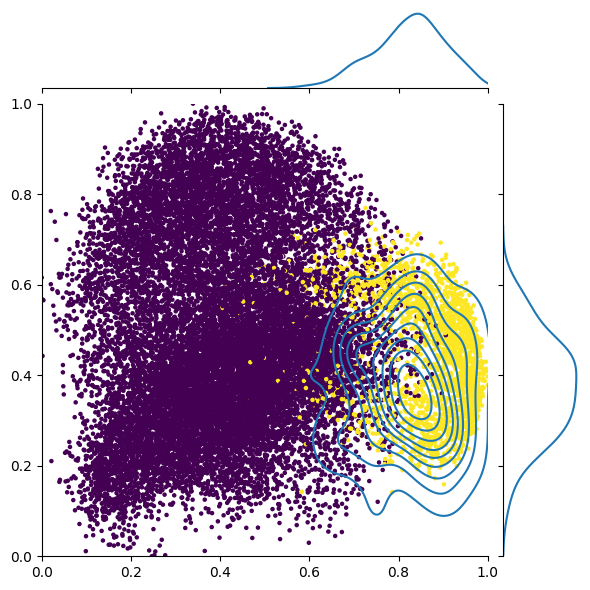

Starting Epoch :  13
Step 1: cost = 0.01052684352446398
Step 65: cost = 0.010383187904616897
Step 129: cost = 0.010239218540300632
Step 193: cost = 0.010094936062085003
Step 257: cost = 0.009950341127584306
Step 321: cost = 0.009805434421540582
Step 385: cost = 0.010390403831836734
Step 449: cost = 0.009520028252119506
Step 513: cost = 0.010853928336791871
Step 577: cost = 0.00923882925993158
Step 641: cost = 0.009092467291092587
Step 705: cost = 0.008945798259166526
Step 769: cost = 0.009559601341993634
Step 833: cost = 0.009422620224355624
Step 897: cost = 0.00851481088358741
Step 961: cost = 0.00991796433308531
Step 1025: cost = 0.009010142810964876
Step 1089: cost = 0.009656528886528862
Step 1153: cost = 0.008738883432750987
Step 1217: cost = 0.009394209052736375
Step 1281: cost = 0.009264964883957526
Step 1345: cost = 0.00833277440441209
Step 1409: cost = 0.009001356801490161
Step 1473: cost = 0.00968274474039656
Step 1537: cost = 0.007929697524757102
Step 1601: cost = 0.006967669

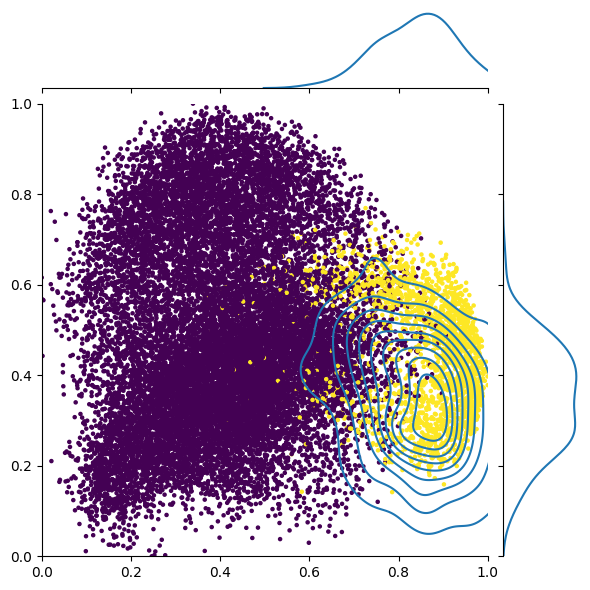

Starting Epoch :  14
Step 1: cost = 0.012401395384421532
Step 65: cost = 0.012329561972774239
Step 129: cost = 0.012257640259738523
Step 193: cost = 0.012185629921813157
Step 257: cost = 0.012113530638103276
Step 321: cost = 0.012041342090349794
Step 385: cost = 0.011969063962954496
Step 449: cost = 0.01189669594301157
Step 513: cost = 0.01182423772033403
Step 577: cost = 0.011751688987485243
Step 641: cost = 0.011679049439802247
Step 705: cost = 0.011606318775429947
Step 769: cost = 0.013348079459971057
Step 833: cost = 0.011467050600769024
Step 897: cost = 0.01230732398315148
Step 961: cost = 0.011324274128182599
Step 1025: cost = 0.01217035242388853
Step 1089: cost = 0.01210313817317332
Step 1153: cost = 0.011111147259923015
Step 1217: cost = 0.011037781398541613
Step 1281: cost = 0.010964322062045895
Step 1345: cost = 0.012758738181300685
Step 1409: cost = 0.01082368706100778
Step 1473: cost = 0.011690016387422255
Step 1537: cost = 0.011622304958701448
Step 1601: cost = 0.010608915

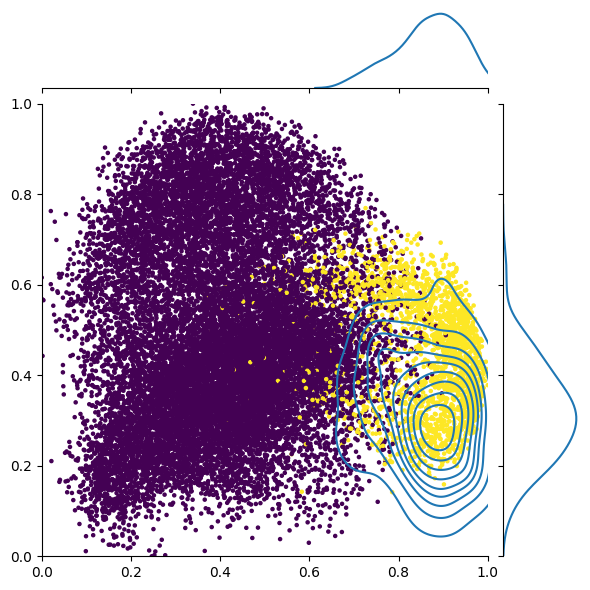

In [28]:
# trainin cycle loop:
# dev.shots = 10
# learning_rate = 0.1
generator_cost = []
dis_cost = []
epochs = 15
for ep in range(epochs):
    print("Starting Epoch : ", ep)
    
    # Train the discriminator first, lock the generator variables:
    disc_weights.requires_grad = True
    gen_weights.requires_grad = False
    for i in range(0, len(pca_data), batch_size):
        if i + batch_size >= len(pca_data):
            x_in_l = np.array(pca_data[i: len(pca_data)], requires_grad=False)
        else:
            x_in_l = np.array(pca_data[i: i+batch_size], requires_grad=False)
            
        x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
        cost = disc_cost(x_in_l, gen_weights, disc_weights)
        dis_cost.append(cost)
        print("Step {}: cost = {}".format(i + 1, cost))
#     for i in range(len(pca_data)):
#         x_in_l = np.array(pca_data[i], requires_grad=False)
#         x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
#         cost = disc_cost(x_in_l,gen_weights, disc_weights)
#         if i % batch_size == 0:
            
#             print("Step {}: cost = {}".format(i + 1, cost))
    test_ind = random.randrange(len(pca_data) - batch_size)        
    test_x = pca_data[test_ind: test_ind + batch_size]
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    
    print("Generator Training starting......")
    # Train the Generator next, lock the discriminator variables:
    disc_weights.requires_grad = False
    gen_weights.requires_grad = True   
    for j in range(0, len(pca_data), batch_size):
        gen_weights, disc_weights = opt.step(gen_cost, gen_weights, disc_weights)
#         gradient = qml.gradients.param_shift(gen_disc_circuit)(gen_weights, disc_weights)
#         gen_weights = update_weights(gen_weights, learning_rate, gradient, True)
        cost = gen_cost(gen_weights, disc_weights)
        generator_cost.append(cost)
#         if i % batch_size == 0:
        print("Step {}: cost = {}".format(j + 1, cost))
            
    print("Checking output : P(Real == True) :", prob_real_true(test_x[random.randrange(len(test_x))], disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    print("Disc Cost = ", disc_cost(test_x, gen_weights, disc_weights))
    # generate distribution graph
    gen_datas = []
    for _ in range(100):
        res = gen_data(gen_weights)
        result = []
        for i in range(len(res)): 
            result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
        gen_datas.append(result)
   
    # Shuffle Input data    
    random.shuffle(pca_data)
    
    generated_data = np.array(gen_datas)
    graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
    graph.x = X[:,0]
    graph.y = X[:,1]
    graph.plot_joint(plt.scatter, marker='o', c=valid_labels, s=5)
    plt.show()

In [1]:
gen_dev.shots= 19
gen_datas = []
for _ in range(100):
    res = gen_data(gen_weights)
    result = []
    for i in range(len(res)): 
        result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
    print(result)
    gen_datas.append(result)

NameError: ignored

In [ ]:
synthetic_points = scaler.inverse_transform(np.array(gen_datas))
synthetic_points = pca.inverse_transform(synthetic_points)

In [ ]:
def generate_and_save_images(synthetic_data):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    fig = plt.figure(figsize=(4,4))
    
    for i in range(synthetic_data.shape[0]):
        plt.subplot(10, 10, i+1)
        dp = np.array((synthetic_data[i] * 127.5) + 127.5).astype('uint8').reshape(imsize,imsize)
        plt.imshow(dp,cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(1010))
    plt.show()

In [ ]:
generate_and_save_images(synthetic_points)